In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [24]:
df = pd.read_csv('./data_주가/애플 주가.csv', encoding='cp949')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.490000,30.642857,30.340000,30.572857,26.419203,123432400
1,2010-01-05,30.657143,30.798571,30.464285,30.625713,26.464878,150476200
2,2010-01-06,30.625713,30.747143,30.107143,30.138571,26.043921,138040000
3,2010-01-07,30.250000,30.285715,29.864286,30.082857,25.995777,119282800
4,2010-01-08,30.042856,30.285715,29.865715,30.282858,26.168606,111902700
...,...,...,...,...,...,...,...
2664,2020-08-04,436.529999,443.160004,433.549988,438.660004,437.870514,43267900
2665,2020-08-05,437.510010,441.570007,435.589996,440.250000,439.457642,30498000
2666,2020-08-06,441.619995,457.649994,439.190002,455.609985,454.790009,50607200
2667,2020-08-07,452.820007,454.700012,441.170013,444.450012,444.450012,49453300


In [25]:
#정규화
from sklearn.preprocessing import MinMaxScaler

In [26]:
scaler = MinMaxScaler()

In [27]:
df.keys()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [28]:
scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
sacled = scaler.fit_transform(df[scale_cols])
sacled

array([[0.00707336, 0.00615119, 0.00763646, 0.00732679, 0.00628865,
        0.24422195],
       [0.00746632, 0.00651361, 0.00793667, 0.00745023, 0.0063946 ,
        0.30315535],
       [0.00739243, 0.00639391, 0.00707399, 0.00631251, 0.00541809,
        0.27605459],
       ...,
       [0.97366801, 1.        , 0.99521727, 1.        , 1.        ,
        0.08552249],
       [1.        , 0.99313399, 1.        , 0.97393591, 0.97601384,
        0.08300793],
       [0.99431038, 0.99406496, 0.99717382, 0.98902321, 0.99099937,
        0.09095672]])

In [29]:
scaled_df = pd.DataFrame(sacled, columns=scale_cols)
scaled_df

,Open,High,Low,Close,Adj Close,Volume
0,0.007073,0.006151,0.007636,0.007327,0.006289,0.244222
1,0.007466,0.006514,0.007937,0.007450,0.006395,0.303155
2,0.007392,0.006394,0.007074,0.006313,0.005418,0.276055
3,0.006509,0.005320,0.006487,0.006182,0.005306,0.235179
4,0.006022,0.005320,0.006491,0.006649,0.005707,0.219097
...,...,...,...,...,...,...
2664,0.961701,0.966275,0.981594,0.960413,0.960751,0.069529
2665,0.964005,0.962574,0.986521,0.964127,0.964433,0.041701
2666,0.973668,1.000000,0.995217,1.000000,1.000000,0.085522
2667,1.000000,0.993134,1.000000,0.973936,0.976014,0.083008


In [30]:
#분할
from sklearn.model_selection import train_test_split

In [31]:
x_train, x_test, y_train, y_test = train_test_split(scaled_df.drop('Close', 1), scaled_df['Close'], test_size=0.2, random_state=0, shuffle=False)

C:\Users\admin\AppData\Local\Temp/ipykernel_6656/1691255756.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(scaled_df.drop('Close', 1), scaled_df['Close'], test_size=0.2, random_state=0, shuffle=False)


In [32]:
x_train.shape, y_train.shape

((2135, 5), (2135,))

In [33]:
x_test.shape, y_test.shape

((534, 5), (534,))

In [34]:
print(type(x_train))

<class 'pandas.core.frame.DataFrame'>


In [35]:
#windowing
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [36]:
WINDOW_SIZE=14
BATCH_SIZE=32
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [37]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 14, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [38]:
model = keras.Sequential([
    # 1차원 feature map 생성
    layers.Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    layers.LSTM(16, activation='tanh'),
    layers.Dense(16, activation="relu"),
    layers.Dense(1),
])

In [39]:
print(np.__version__)
print(tf.__version__)

1.19.5
2.3.0


In [40]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [42]:
#test2
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [43]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     67/Unknown - 0s 3ms/step - loss: 0.0020 - mse: 0.0040
Epoch 00001: val_loss improved from inf to 0.00216, saving model to tmp\ckeckpointer.ckpt
67/67 [==============================] - 1s 18ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 0.0022 - val_mse: 0.0043
Epoch 2/50
53/67 [======================>.......] - ETA: 0s - loss: 1.3840e-04 - mse: 2.7680e-04
Epoch 00002: val_loss improved from 0.00216 to 0.00058, saving model to tmp\ckeckpointer.ckpt
67/67 [==============================] - 0s 6ms/step - loss: 1.1982e-04 - mse: 2.3964e-04 - val_loss: 5.7795e-04 - val_mse: 0.0012
Epoch 3/50
56/67 [========================>.....] - ETA: 0s - loss: 3.5489e-05 - mse: 7.0978e-05
Epoch 00003: val_loss did not improve from 0.00058
67/67 [==============================] - 0s 4ms/step - loss: 3.5761e-05 - mse: 7.1523e-05 - val_loss: 6.2601e-04 - val_mse: 0.0013
Epoch 4/50
57/67 [========================>.....] - ETA: 0s - loss: 3.3037e-05 - mse: 6.6074e-05
Epoch 00004: val_loss 

In [44]:
pred = model.predict(test_data)

In [45]:
pred.shape

(520, 1)

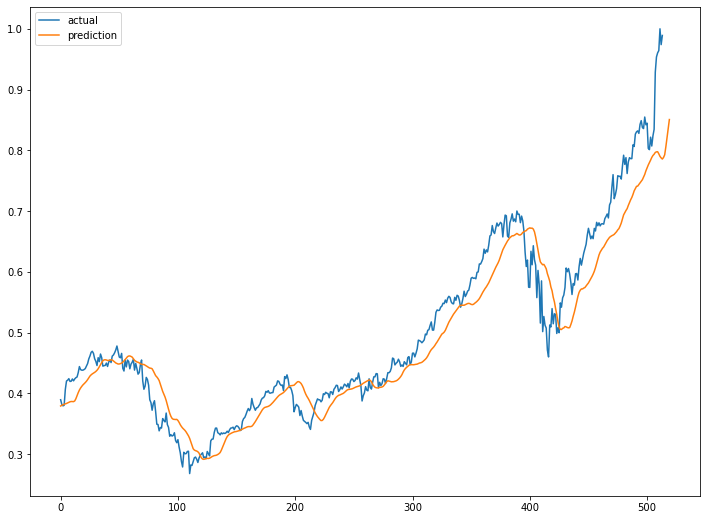

In [46]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

NameError: name 'train_ds' is not defined